<h1>1.4</h1>

In our proposal, we would like to analyze the gas consumption data further by applying clustering method to measure the similarity between the households, and group them based on energy usage. The goal in clustering time‐series data is to understand user behavior by organizing the data into homogeneous groups, maximizing the similarity and dissimilarity within and between groups, respectively.

Clustering is a collection of same group similar or data objects or in other groups. Its also finding the dissimilar to the data objects in other groups.In cluster analysis, the main objective is to find similarities between data objects with the help of specific characteristics found in the data and grouping these similar data objects into clusters. In our project, the following features and their respective standard deviation will be examined in the following clustering discussion.    

<table>
<tr>
<th>Features</th>
<th>Discription</th>
</tr>
<tr>
<td>Total consumption</td>
<td>Total consumed power during period of the study</td>
</tr>
<tr>
<td>Morning consumtption</td>
<td>The consumption observed from 06:00 - 09:00</td>
</tr>
<tr>
<td>Noon consumtption</td>
<td>The consumption observed from 11:00 - 14:00</td>
</tr>
<tr>
<td>Night consumtption</td>
<td>The consumption observed from 17:00 - 20:00</td>
</tr>
</table>

Potential application areas for work using this form of cluster analysis as more smart data becomes routinely available include
1. Application of cluster results for segment-specific rate design: the economic benefits of time-variable natural gas rates consist in the potential for utilities to improve price discrimination and to facilitate the reduction of peak loads. A complete design of gas scheme would encompass number of different time zones and starting time of each period. All these could be done through clustering analysis. In addition, by influencing the demand side, segment-specific natural gas rates can improve the energy system’s efficiency.

2. Application of cluster results for leak detection activities based on detecting pattern changes (deviation from cluster centroids/ distributions); data-driven models of demand could also help identify atypical customers or unusual changes in consumption. 

3. Application of cluster results for filling missing data for audits/ regulatory purposes using cluster centroids. Typical usage perhaps allows volumetric usage and flow profiles to be estimated for unmetered customers.

In [317]:
import numpy as np
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from pathlib import Path
import timeit
import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pylab as pl
from sklearn.decomposition import PCA
from IPython.display import HTML
from sklearn.datasets import load_iris
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from __future__ import print_function


In [318]:
# headers include all features needed for later discussion
path = str(Path().resolve().parent)+'\csv'
df = pd.read_csv(path+"/hourly_readings_with_consumption.csv")

headers = ["dataid", "totalConsumption", "morningTotal","morningMean", "morningSTD", "noonTotal","noonMean",
          "noonSTD", "nightTotal","nightMean", "nightSTD","elseConsumption"]
currentID = df.iloc[0]['dataid']
baseTime = df.iloc[0]['time'] 
featuresList = []
morningConsumption = []
noonConsumption = []
nightConsumption = []
totalConsumption = 0
elseConsumption = []
currentMorning = 0
currentNoon = 0
currentNight = 0
currentElse = 0
prevDay = df.iloc[0]['day']

In [319]:
# Feature Extraction 
for row in df.itertuples():
    currentTime = row.time
    hrs_diff = int(currentTime.split(":")[0][:2])
    currentDay = row.day
    if (currentDay != prevDay):
        morningConsumption.append(currentMorning)
        noonConsumption.append(currentNoon)
        nightConsumption.append(currentNight)
        elseConsumption.append(currentElse)
        prevDay = currentDay
        currentMorning = 0
        currentNoon = 0
        currentNight = 0
        currentElse = 0
        
    if (currentID != row.dataid):
        features = []
        morningTotal = np.sum(morningConsumption)
        morningMean = np.mean(morningConsumption)
        morningSTD = np.std(morningConsumption)
        
        noonTotal = np.sum(noonConsumption)
        noonMean = np.mean(noonConsumption)
        noonSTD = np.std(noonConsumption)
        
        nightTotal = np.sum(nightConsumption)
        nightMean = np.mean(nightConsumption)
        nightSTD = np.std(nightConsumption)
        elseConsumptionTotal = np.sum(elseConsumption)
        
        features.append(currentID)
        features.append(totalConsumption)
        features.append(morningTotal)
        features.append(morningMean)
        features.append(morningSTD)
        features.append(noonTotal)
        features.append(noonMean)
        features.append(noonSTD)
        features.append(nightTotal)
        features.append(nightMean)
        features.append(nightSTD)
        
        features.append(elseConsumptionTotal)
        featuresList.append(features)
        
        elseConsumption =[]
        morningConsumption = []
        noonConsumption = []
        nightConsumption = []
        totalConsumption = 0
        currentID = row.dataid
    
    totalConsumption = totalConsumption + int(row.consumption)
    if (hrs_diff >= 6 and hrs_diff <= 9):
        currentMorning = currentMorning + int(row.consumption)
    elif (hrs_diff >= 11 and hrs_diff <= 14):
        currentNoon = currentNoon + int(row.consumption)
    elif (hrs_diff >= 17 and hrs_diff <= 20):
        currentNight = currentNight + int(row.consumption)
    else:
        currentElse = currentElse + int(row.consumption)

morningConsumption.append(currentMorning)
noonConsumption.append(currentNoon)
nightConsumption.append(currentNight)
morningMean = np.mean(morningConsumption)
morningSTD = np.std(morningConsumption)
noonMean = np.mean(noonConsumption)
noonSTD = np.std(noonConsumption)
nightMean = np.mean(nightConsumption)
nightSTD = np.std(nightConsumption)
features = []

features.append(currentID)
features.append(totalConsumption)
features.append(morningTotal)
features.append(morningMean)
features.append(morningSTD)
features.append(noonTotal)
features.append(noonMean)
features.append(noonSTD)
features.append(nightTotal)
features.append(nightMean)
features.append(nightSTD)
features.append(elseConsumptionTotal)
featuresList.append(features)

featureFrame = pd.DataFrame(featuresList)
featureFrame.to_csv(path + '/reading_features.csv', header=headers, index=None)

K-medoids clustering selects the most centrally located data points within clusters as cluster centers called medoids and returns the number of clustering as required.

In [320]:
df = pd.read_csv(path+"/reading_features.csv")
featureNames = ["totalConsumption", "morningTotal", "noonTotal", "nightTotal"]
# featureNames = ["totalConsumption", "morningMean", "noonMean", "nightMean"]

# Normalise the data for range o to 1
x = df[featureNames].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_scaled = min_max_scaler.fit_transform(x)
df_normalized = pd.DataFrame(x_scaled)

For n_clusters = 2 The average silhouette_score is : 0.39422206155399053
For n_clusters = 3 The average silhouette_score is : 0.4093610950348011
For n_clusters = 4 The average silhouette_score is : 0.4025451361001917
For n_clusters = 5 The average silhouette_score is : 0.34146348203370286
For n_clusters = 6 The average silhouette_score is : 0.35130206994440766


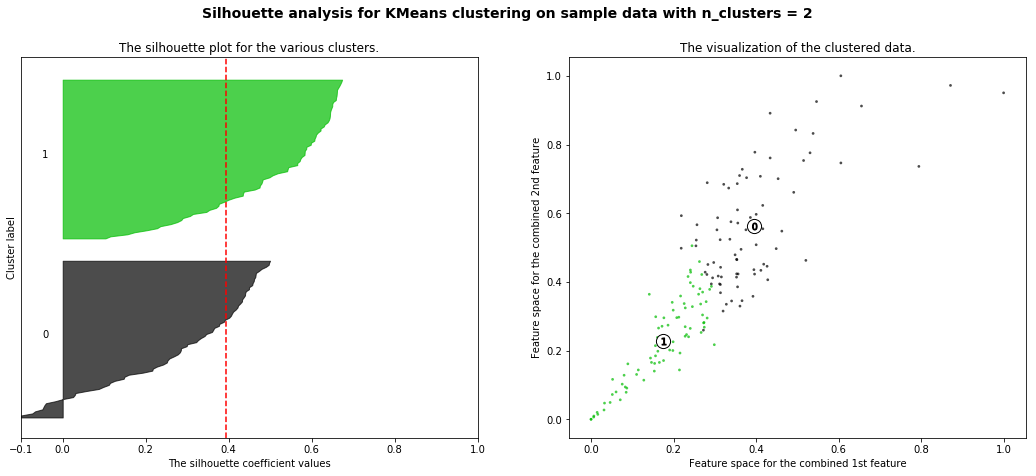

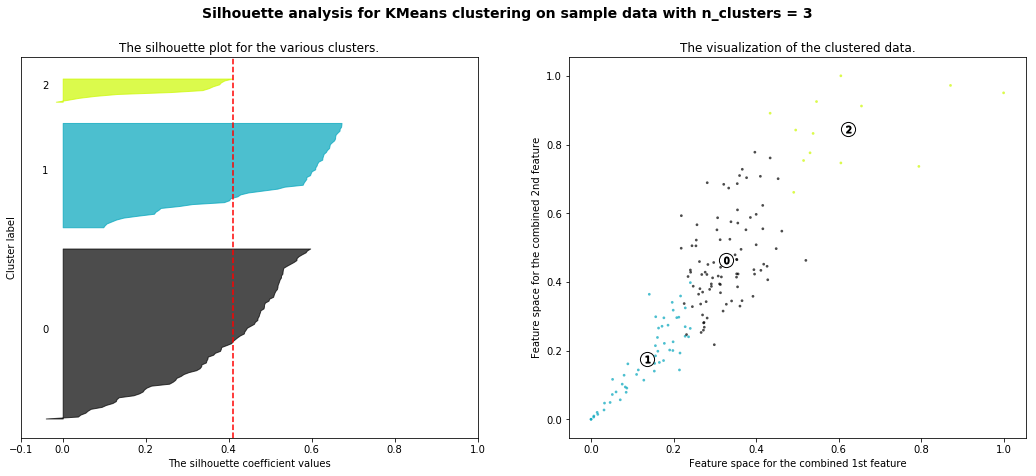

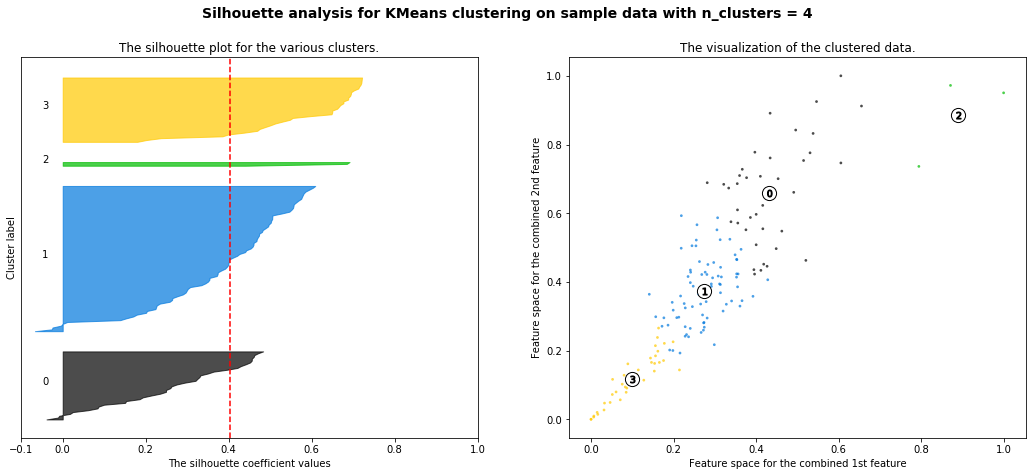

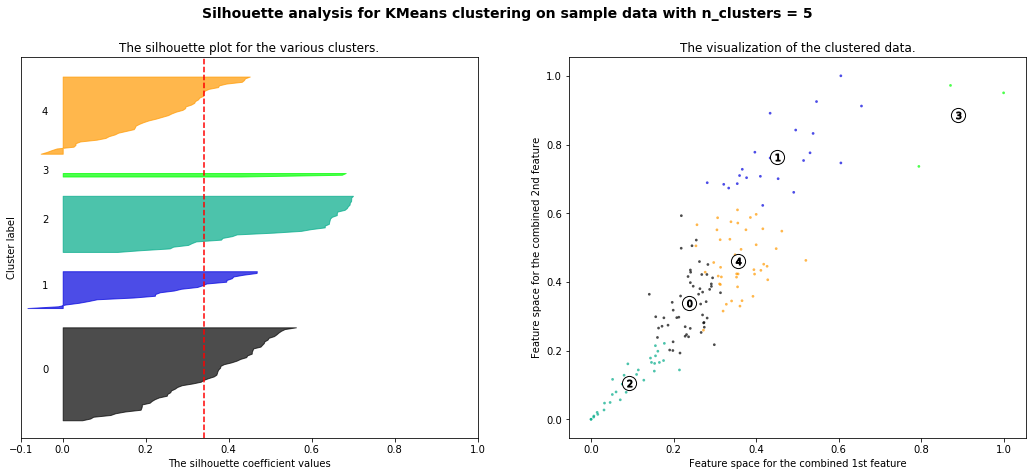

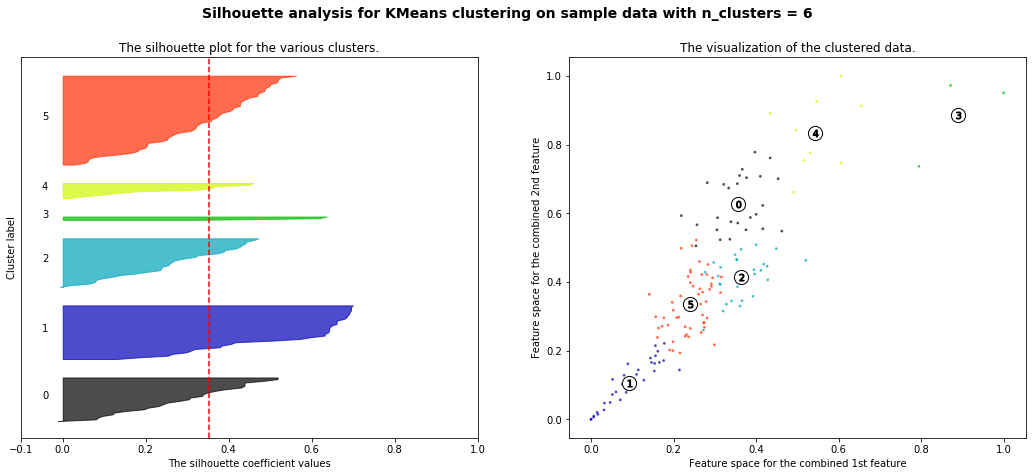

In [321]:
range_n_clusters = [2, 3, 4, 5, 6]
X= df_normalized.values

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # In our example, the silhouette coefficient can range from -0.1. The higher, the better.
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the combined 1st feature")
    ax2.set_ylabel("Feature space for the combined 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

Figure above provides a silhouette plot for k-means applied with diferent cluster numbers ranging from 2 to 6. From all the plots, 3 clusters have a highes taverage silhouette score which will be used for further discussion.

In [322]:
kmeans = KMeans(n_clusters=3).fit(df_normalized)
df.insert(loc=0, column="classification", value=kmeans.labels_)
df.to_csv(path + '/reading_features_classification.csv', index=None)

Text(0,0.5,'Morning Average Consumption')

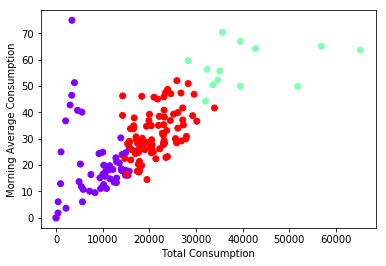

In [323]:
df_array = df.values
plt.scatter(df_array[:,2],df_array[:,4], c=kmeans.labels_, cmap='rainbow')  
plt.xlabel('Total Consumption')
plt.ylabel('Morning Average Consumption')

Text(0,0.5,'Noon Average Consumption')

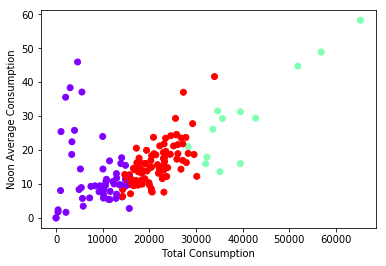

In [324]:
df_array = df.values
plt.scatter(df_array[:,2],df_array[:,7], c=kmeans.labels_, cmap='rainbow')  
plt.xlabel('Total Consumption')
plt.ylabel('Noon Average Consumption')

Text(0,0.5,'Night Average Consumption')

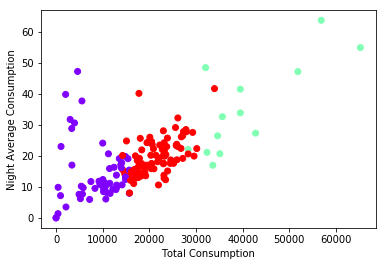

In [325]:
df_array = df.values
plt.scatter(df_array[:,2],df_array[:,10], c=kmeans.labels_, cmap='rainbow')  
plt.xlabel('Total Consumption')
plt.ylabel('Night Average Consumption')

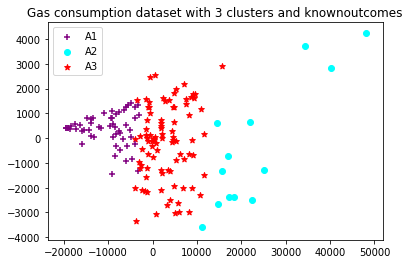

In [326]:
pca = PCA(n_components=2).fit(df[featureNames])
pca_2d = pca.transform(df[featureNames])
for i in range(0, pca_2d.shape[0]):
    if df.classification[i] == 0:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='purple',marker='+')
    elif df.classification[i] == 1:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='cyan',marker='o')
    elif df.classification[i] == 2:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='red',marker='*')
pl.legend([c1, c2, c3], ['A1', 'A2','A3'])
pl.title('Gas consumption dataset with 3 clusters and knownoutcomes')
pl.show()

In conclusion, data clustering is used to find similar groups having the same gas consumption patterns. Smart meter data clustering has been widely investigated toward consumers grouping and revealing their energy usage behavior which leads to more efficient tariff policy and tailored energy efficiency programs for specific users. More specific data analysis and comparison will be shown in section 3.